Udacity Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
# Import libraries
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline


In [2]:
#Load training data
car_images = glob.glob('vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/**/*.png')
print('Found',len(car_images), 'car images and',len(noncar_images),'non-car images.')

Found 8792 car images and 8968 non-car images.


In [3]:
#Function definitions

def extract_HOG(img, orient, pix_per_cell, cells_per_block, feature_vec=True):
   
    features = hog(img, orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cells_per_block, cells_per_block), 
                   transform_sqrt=False, 
                   visualise=False, feature_vector=feature_vec)
    return features

def get_HOG_images(img, orient, pix_per_cell, cells_per_block, feature_vec=True):
    features, hog_image = hog(img, orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cells_per_block, cells_per_block), 
                              transform_sqrt=False, 
                              visualise=True, feature_vector=feature_vec)
    return features, hog_image

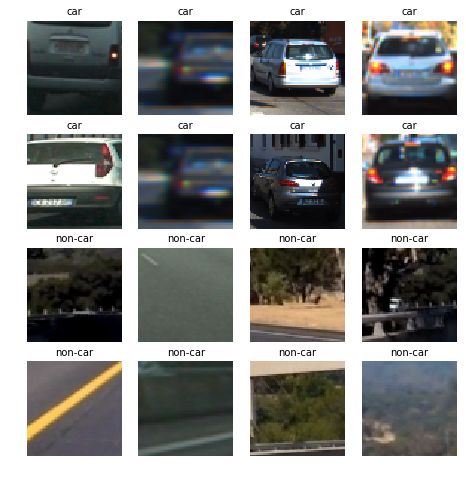

In [4]:
#Some car and non-car images:
fig, axs = plt.subplots(4,4, figsize=(8, 8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(8):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=10)
    axs[i].imshow(img)

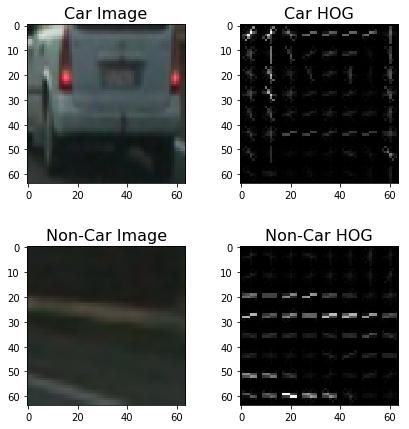

In [5]:
#skimage.hog() output examination

car_img = mpimg.imread(car_images[5])
_, car_dst = get_HOG_images(car_img[:,:,2], 9, 8, 8, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_HOG_images(noncar_img[:,:,2], 9, 8, 8, feature_vec=True)
 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

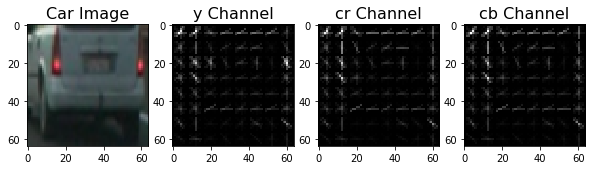

In [6]:
#YCrCB color space example

car_img = mpimg.imread(car_images[5])
feature_image = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
hog_features = []
orient = 8
pix_per_cell = 8
cells_per_block = 2

featuresVec, yChannel = get_HOG_images(car_img[:,:,0], 8, 8, 2, feature_vec=True)
hog_features.append(featuresVec)

featuresVec, crChannel = get_HOG_images(car_img[:,:,1], 8, 8, 2, feature_vec=True)
hog_features.append(featuresVec)

featuresVec, cbChannel = get_HOG_images(car_img[:,:,2], 8, 8, 2, feature_vec=True)
hog_features.append(featuresVec)

hog_features = np.ravel(hog_features)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(yChannel, cmap='gray')
ax2.set_title('y Channel', fontsize=16)
ax3.imshow(crChannel, cmap='gray')
ax3.set_title('cr Channel', fontsize=16)
ax4.imshow(cbChannel, cmap='gray')
ax4.set_title('cb Channel', fontsize=16)

In [7]:
#Extract feature from all car and non-car images.
def extract_HOG_features(imgs, orient, pix_per_cell, cells_per_block):
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(extract_HOG(feature_image[:,:,channel], 
                                orient, pix_per_cell, cells_per_block, 
                                feature_vec=True))
        hog_features = np.ravel(hog_features)
         # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [8]:
orient = 11
pix_per_cell = 16
cells_per_block = 2
car_features = extract_HOG_features(car_images, orient=orient, 
                        pix_per_cell=pix_per_cell, cells_per_block=cells_per_block)
notcar_features = extract_HOG_features(noncar_images, orient=orient, 
                        pix_per_cell=pix_per_cell, cells_per_block=cells_per_block)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cells_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [9]:
#Classifier Training
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


0.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9806


In [10]:
def detect_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cells_per_block, spatial_size, hist_bins,all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)        
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
   
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cells_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = extract_HOG(ch1, orient, pix_per_cell, cells_per_block, feature_vec=False)   
    hog2 = extract_HOG(ch2, orient, pix_per_cell, cells_per_block, feature_vec=False)
    hog3 = extract_HOG(ch3, orient, pix_per_cell, cells_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                        
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

4 rectangles found in image


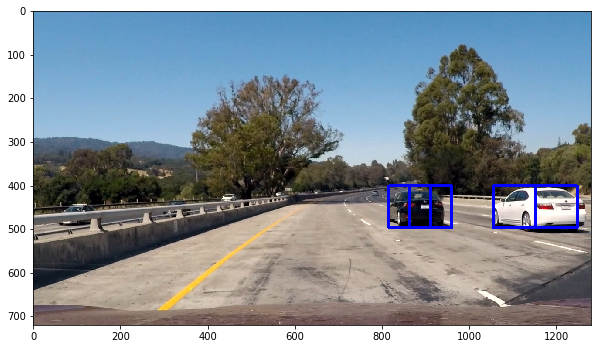

In [11]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

orient = 11
pix_per_cell = 16
cells_per_block = 2


rectangles = detect_cars(test_img, ystart, ystop, scale, svc, None, orient, pix_per_cell, cells_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

Number of boxes:  78


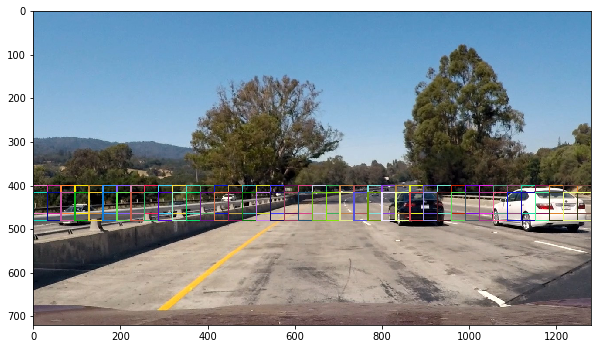

In [12]:
#Find search area
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  50


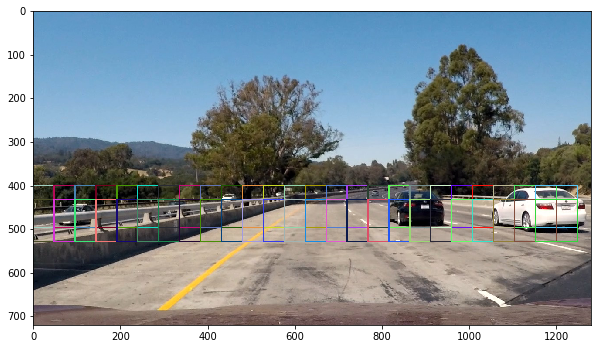

In [13]:
rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


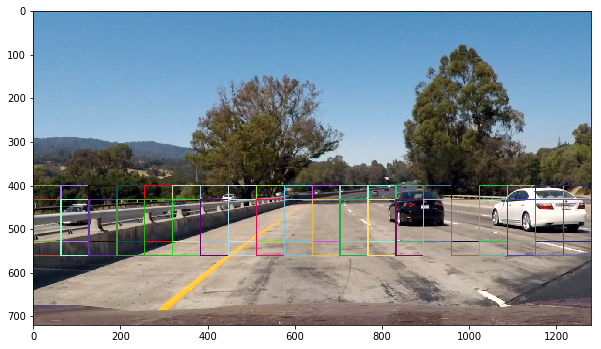

In [14]:
rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


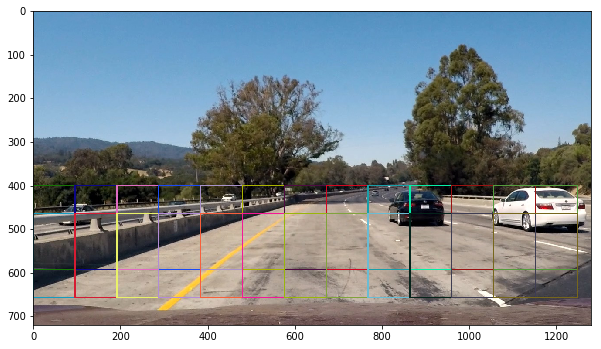

In [15]:
rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None,all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

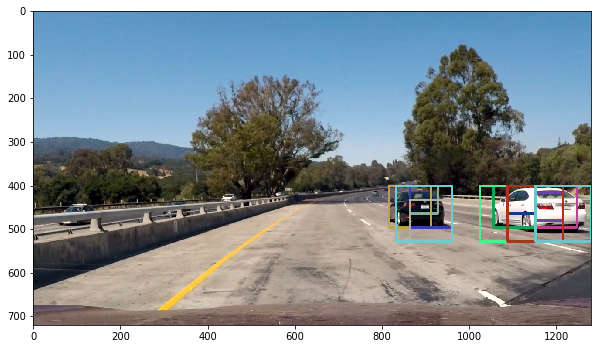

In [16]:
#Select sliding windows
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

orient = 11
pix_per_cell = 16
cells_per_block = 2


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

ystart = 416
ystop = 480
scale = 1.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


In [17]:
def generate_heatmap(heatmap, bbox_list,threshold=-1):
    # Iterate through list of bboxes
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    if(threshold>0):
        heatmap[heatmap <= threshold] = 0
    
    return heatmap


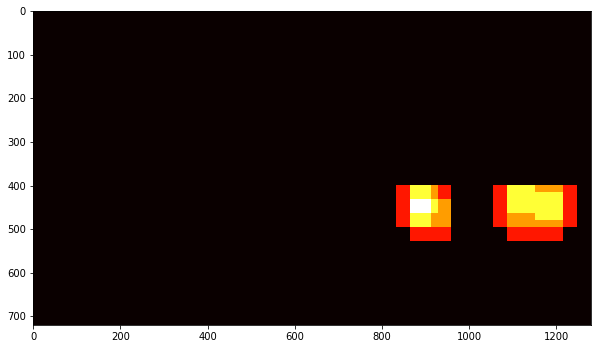

In [18]:
#Heatmap test
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = generate_heatmap(heatmap_img, rectangles,1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


In [19]:
#Draw bounding boxes
def draw_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

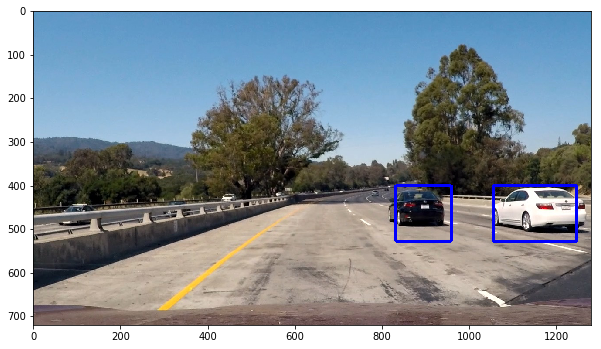

In [20]:
labels = label(heatmap_img)
draw_img, rect = draw_bboxes(np.copy(test_img), labels)

plt.figure(figsize=(10,10))
plt.imshow(draw_img)

Pipeline

In [21]:
def process_frame(img):

    rectangles = []

    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_image = np.zeros_like(img[:,:,0])
    heatmap_image = generate_heatmap(heatmap_image, rectangles,1)
    labels = label(heatmap_image)
    final_img, rects = draw_bboxes(np.copy(img), labels)
    return final_img


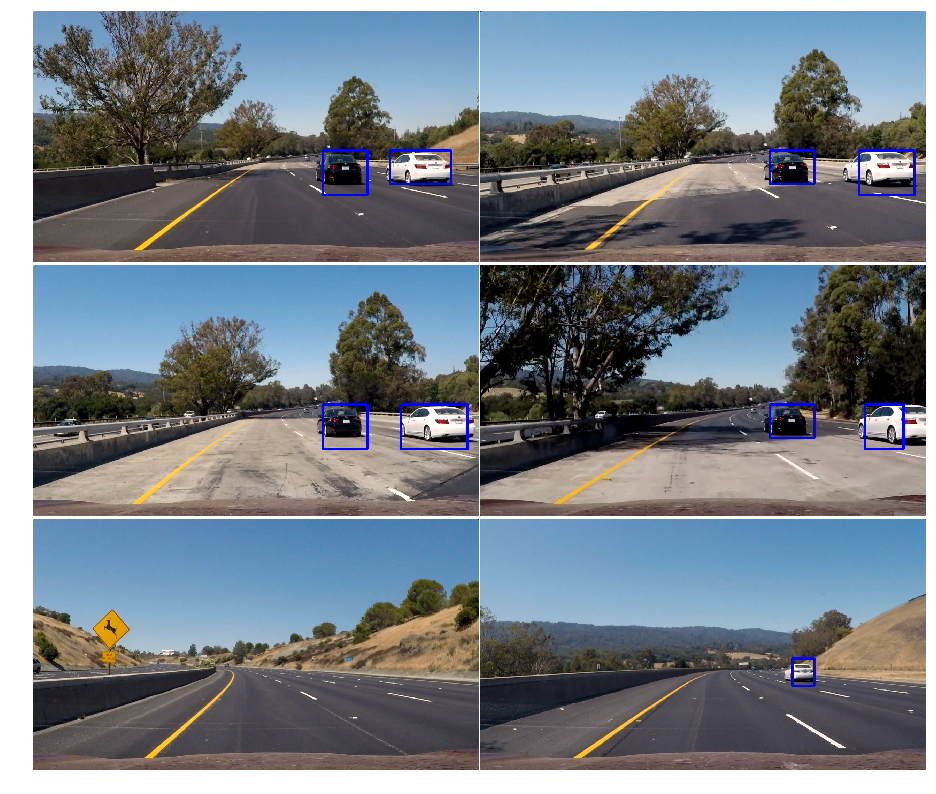

In [22]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')


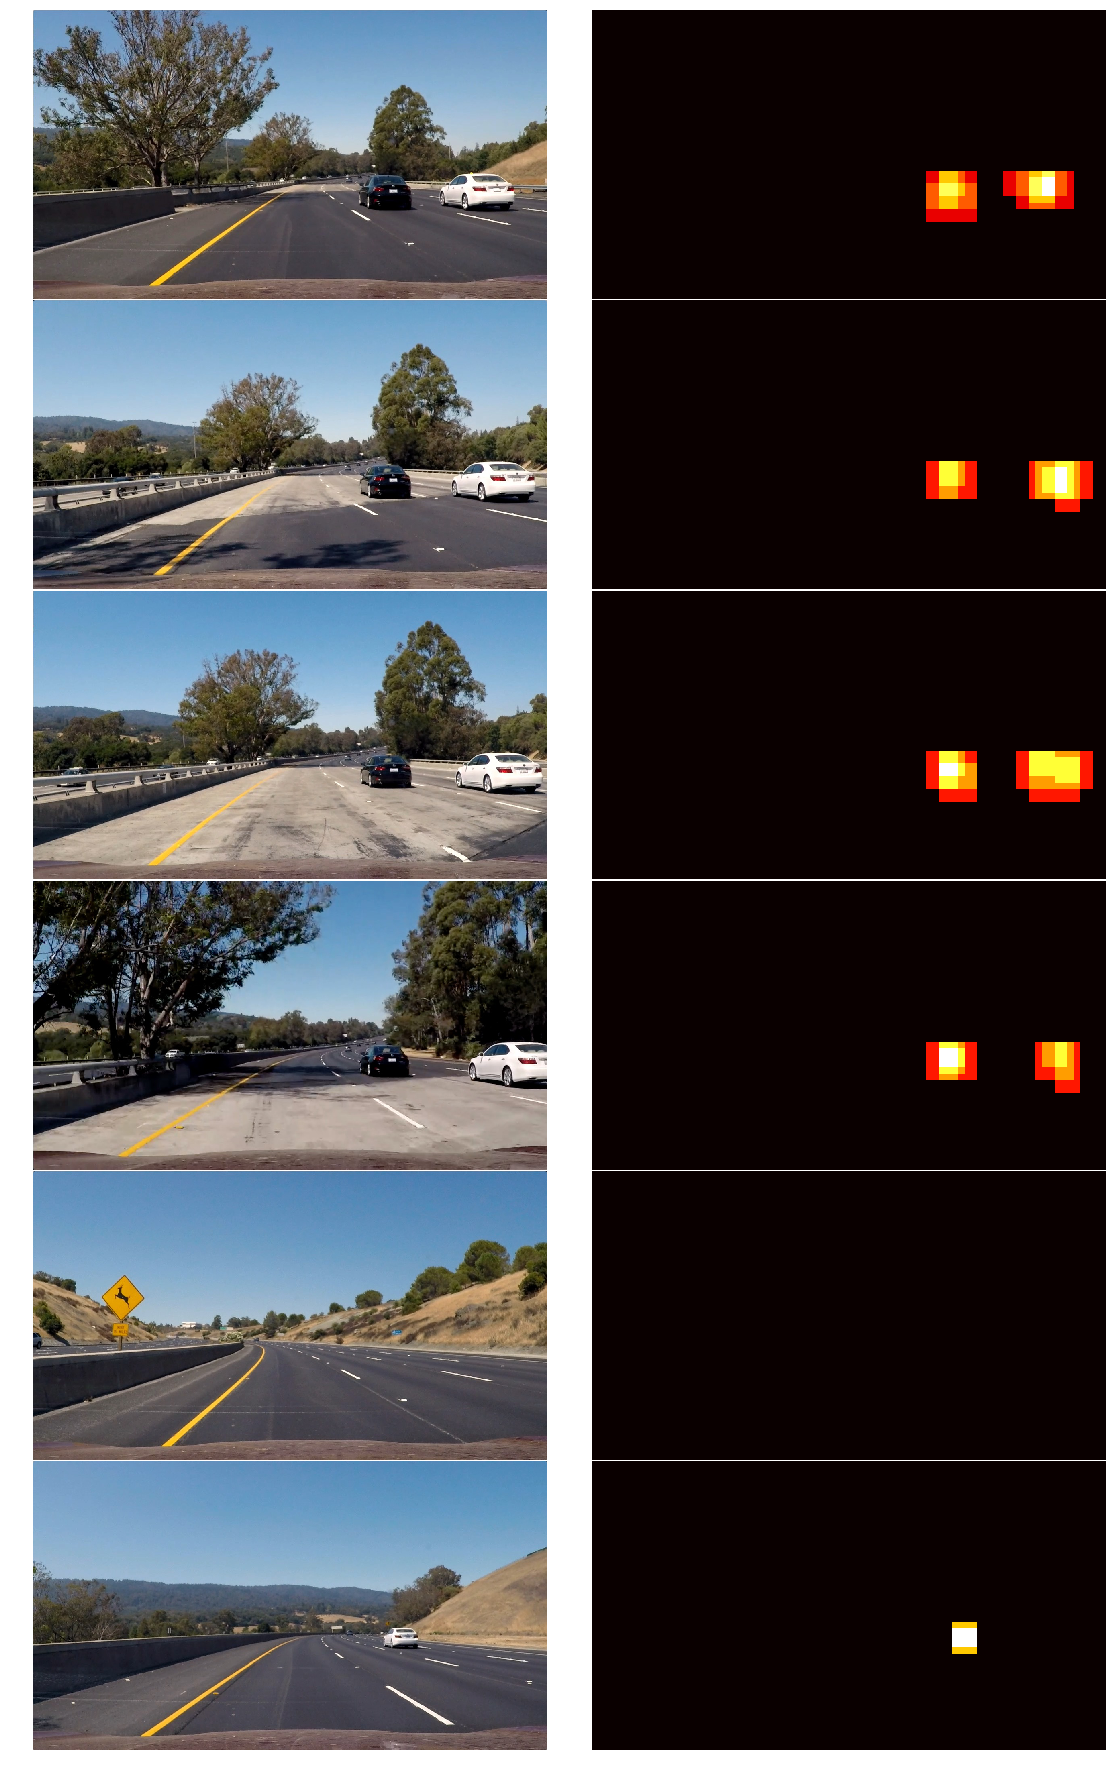

In [45]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(6, 2, figsize=(20,32))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

k = 0
for i, im in enumerate(test_images):

    rectangles = []
    test_img = mpimg.imread(im)
    orient = 11
    pix_per_cell = 16
    cells_per_block = 2


    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))

    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 

    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = generate_heatmap(heatmap_img, rectangles,1)
    axs[k].imshow(test_img)
    axs[k].axis('off')
    axs[k+1].imshow(heatmap_img,cmap='hot')
    axs[k+1].axis('off')
    k = k + 2

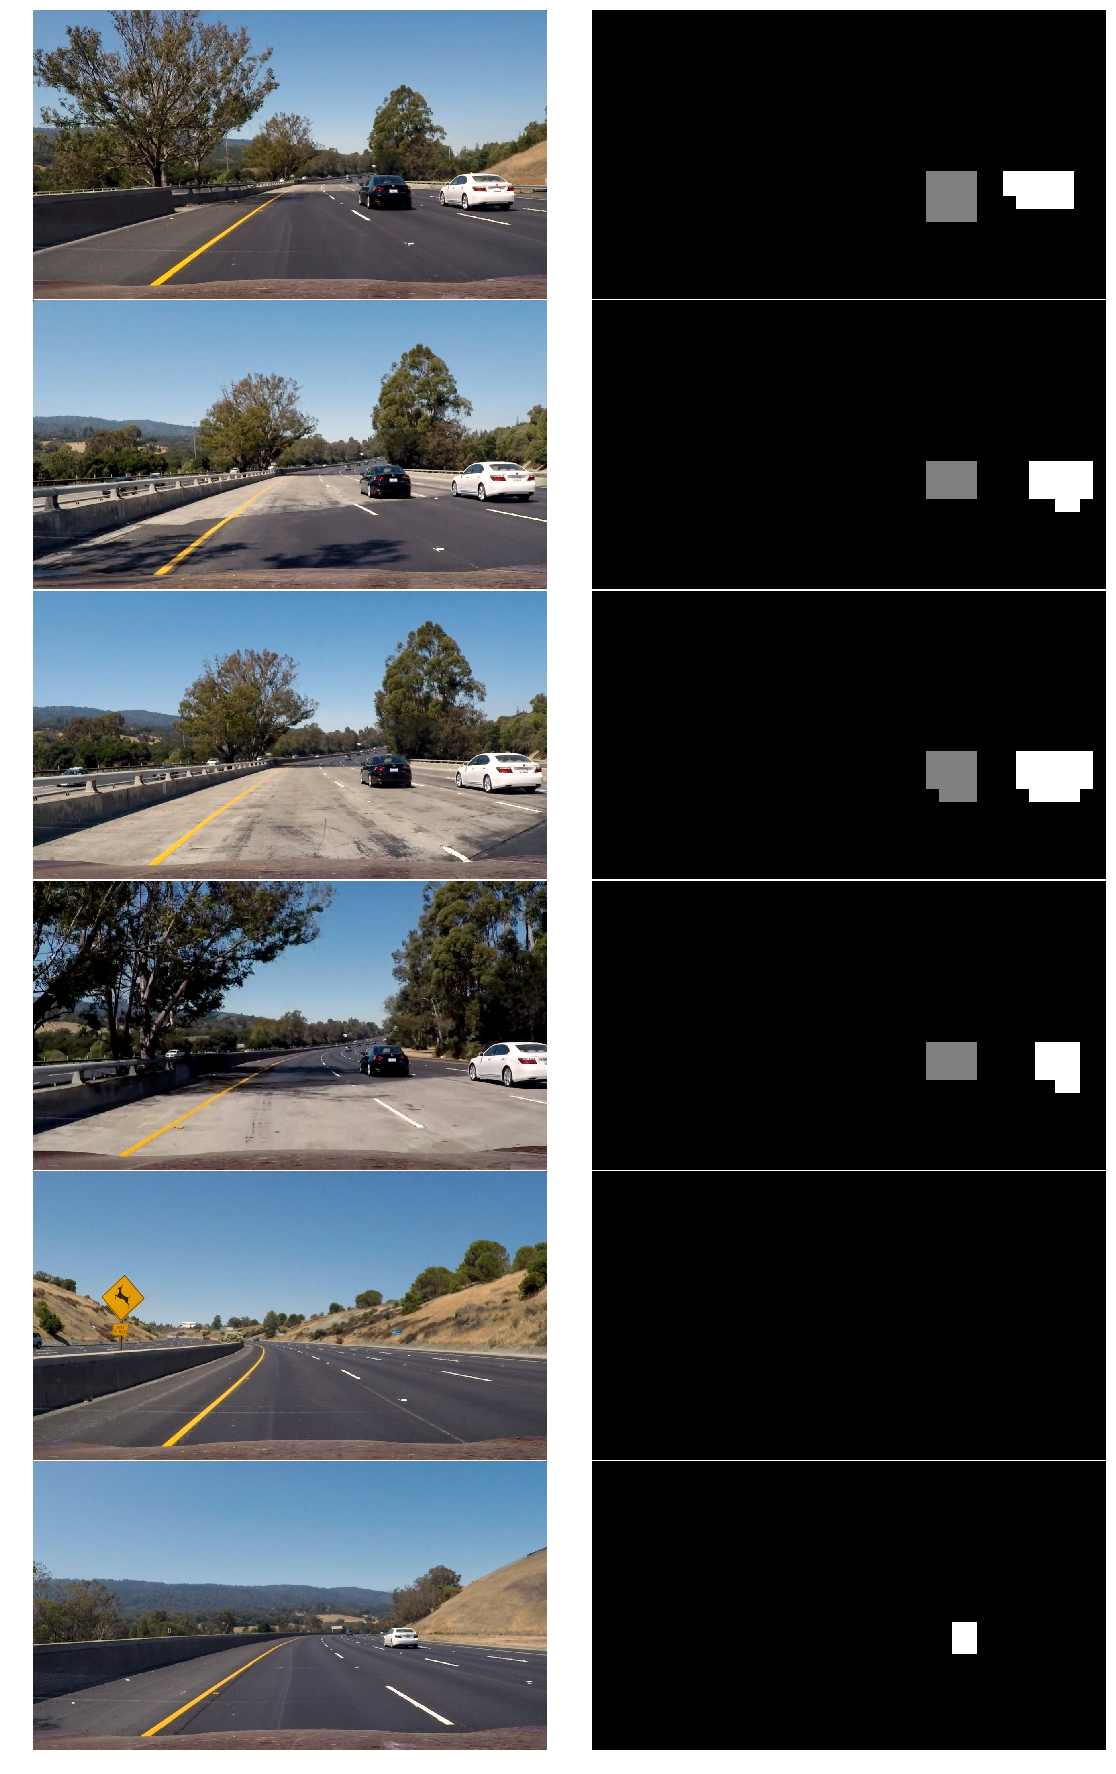

In [44]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(6, 2, figsize=(20,32))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

k = 0
for i, im in enumerate(test_images):

    rectangles = []
    test_img = mpimg.imread(im)
    orient = 11
    pix_per_cell = 16
    cells_per_block = 2


    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(detect_cars(test_img, ystart, ystop, scale, svc, None, 
                           orient, pix_per_cell, cells_per_block, None, None))

    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 

    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = generate_heatmap(heatmap_img, rectangles,1)
    labels = label(heatmap_img)
    axs[k].imshow(test_img)
    axs[k].axis('off')
    axs[k+1].imshow(labels[0], cmap='gray')
    axs[k+1].axis('off')
    k = k + 2

In [23]:
#Apply pipeline to a video
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 36.7 s, sys: 140 ms, total: 36.9 s
Wall time: 11.1 s


In [24]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [25]:
def process_video_frame(img):
    
    rectangles = []

    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, svc, None, 
                       orient, pix_per_cell, cells_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 

    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)

    heatmap_image = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_image = generate_heatmap(heatmap_image, rect_set,1)
        # + len(det.prev_rects)//8
    labels = label(heatmap_image)
    final_img, rects = draw_bboxes(np.copy(img), labels)
    return final_img

In [26]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_video_frame)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 36.5 s, sys: 164 ms, total: 36.6 s
Wall time: 11.1 s


In [27]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_video_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:27<00:00,  3.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 19min 6s, sys: 2.18 s, total: 19min 9s
Wall time: 5min 27s
